RESPOSNES OF THE LIFT OSCILLATOR, AT DIFFERENT VALUES OF VELOCITIES

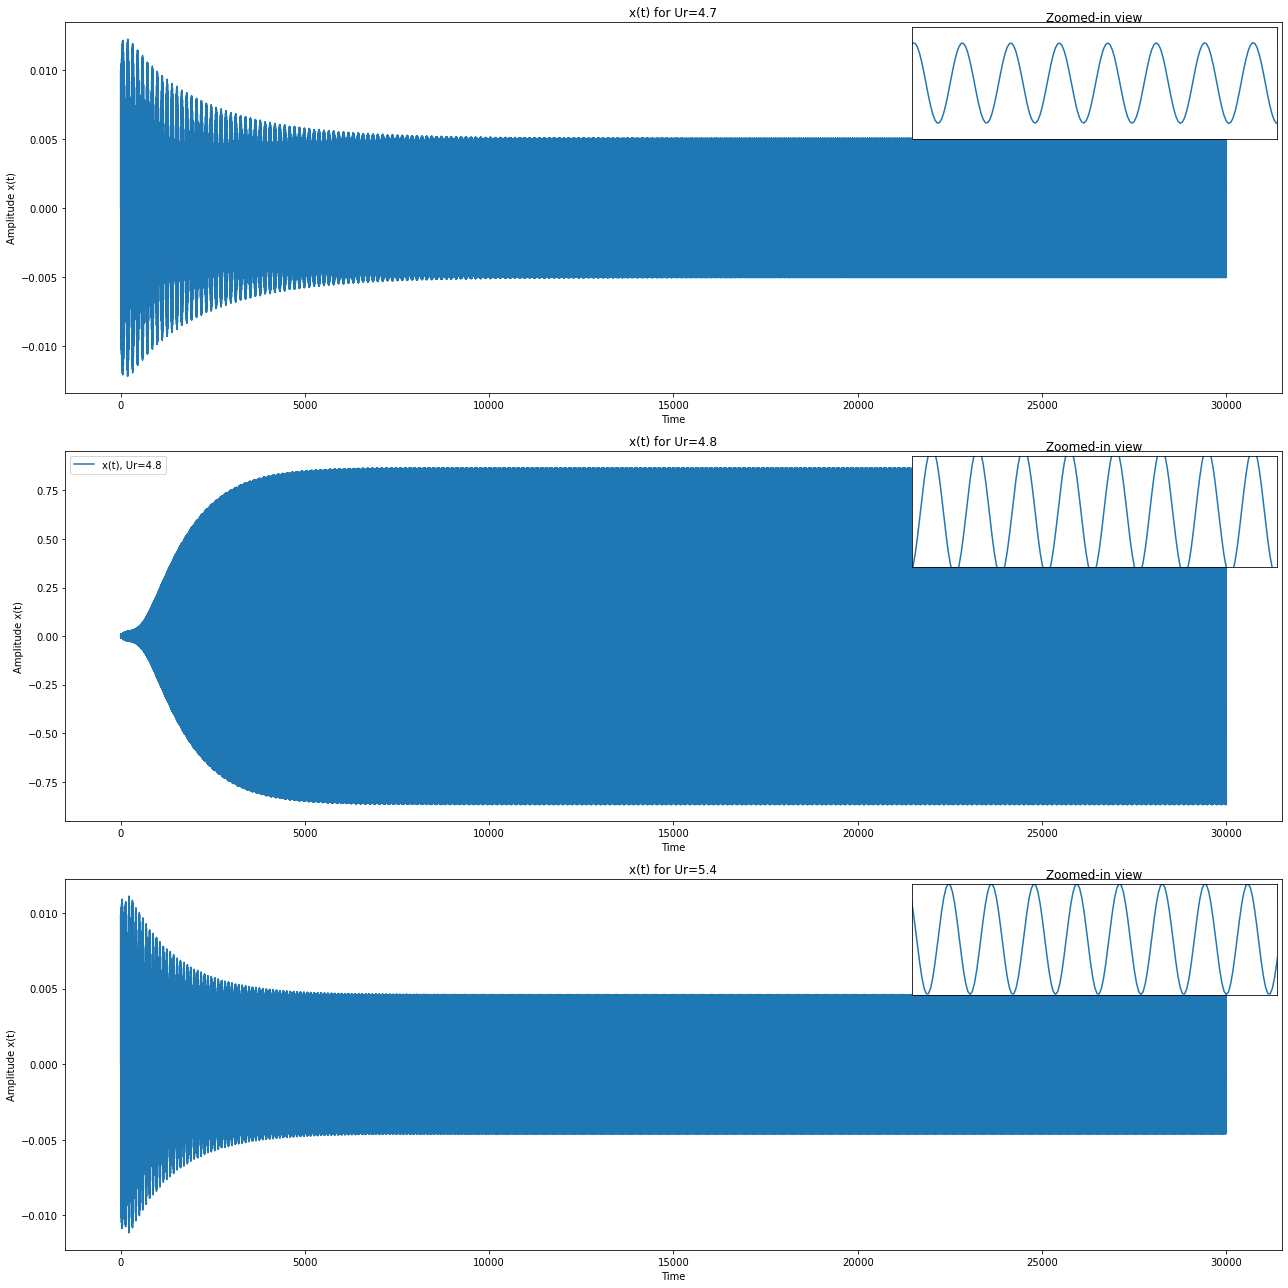

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

a = 0.002
#omega_knot = 23.5
S = 0.2
Ur = 4.7
omega_knot = S*Ur
zeta = 0.0015
b = 0.4
gamma = 1.21
alpha = 0.02

def odes(state, t, a, omega_knot, zeta):
    x, v, Cl, p = state
    x_dot = v
    v_dot = 2 * a * omega_knot**2 * Cl - x - (2 * zeta * v)
    Cl_dot = p
    p_dot = b*v_dot + alpha*omega_knot*p - (gamma/omega_knot)*p**3 - omega_knot**2*Cl
    return [x_dot, v_dot, Cl_dot, p_dot]

initial_state = [0.0, 0.01, 0, 0]
t_points = np.linspace(0, 30000, 100000)


Ur_values = [4.7, 4.8, 5.4]

fig, axes = plt.subplots(len(Ur_values), 1, figsize=(18, 6 * len(Ur_values)))

for i, Ur in enumerate(Ur_values):
    omega_knot = S * Ur
    solution = odeint(odes, initial_state, t_points, args=(a, omega_knot, zeta))

    x_t = solution[:, 0]


    axes[i].plot(t_points, x_t, label=f'x(t), Ur={Ur}')
    axes[i].set_title(f'x(t) for Ur={Ur}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude x(t)')
    axes[i].legend()


    axins = inset_axes(axes[i], width="30%", height="30%", loc='upper right')
    axins.plot(t_points, x_t, label=f'x(t), Ur={Ur}')
    zoom_start, zoom_end = 9950, 10000
    axins.set_xlim(zoom_start, zoom_end)
    axins.set_ylim(min(x_t[zoom_start:zoom_end]), max(x_t[zoom_start:zoom_end]))
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_title('Zoomed-in view')

plt.tight_layout()
plt.show()
plt.savefig('wake-Lift', dpi=300)

DATA PRE PROCESSING FOR THE LASSO MODEL

In [ ]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('CFD_Time_series_stable_data_Re_150.csv')
df = df[df['Time']>=250]
X = df.iloc[:, 1]
X.shape
print(X.min())
print(X.max())
X = df.iloc[:, 1]
X_centered = X - X.mean()
print(X_centered.min())
print(X_centered.max())
Normalized_X = X_centered.to_numpy()
Cl = Normalized_X

1.36259
1.419083
-0.02836129312133906
0.028131706878661067


In [ ]:
import numpy as np
from scipy.signal import savgol_filter
C_L = Normalized_X
dt = 0.003
dC_L = np.gradient(C_L, dt)
ddC_L = np.gradient(dC_L, dt)
from sklearn.linear_model import Lasso
def library(C_L, dC_L):
    return np.column_stack([ dC_L,C_L, dC_L**3])
    #return np.column_stack([C_L, dC_L, C_L**2, dC_L**2, C_L * dC_L, dC_L**3])
Theta = library(C_L, dC_L)
model = Lasso(alpha=0.00)
model.fit(Theta, ddC_L)
Xi = model.coef_
print(Xi)

[ 2.11646581e-03 -5.72650716e+00 -6.19408799e-01]


VALIDATION OF RESPONSES FROM SINDY, WITH THE ACTUAL MODEL RESONSES

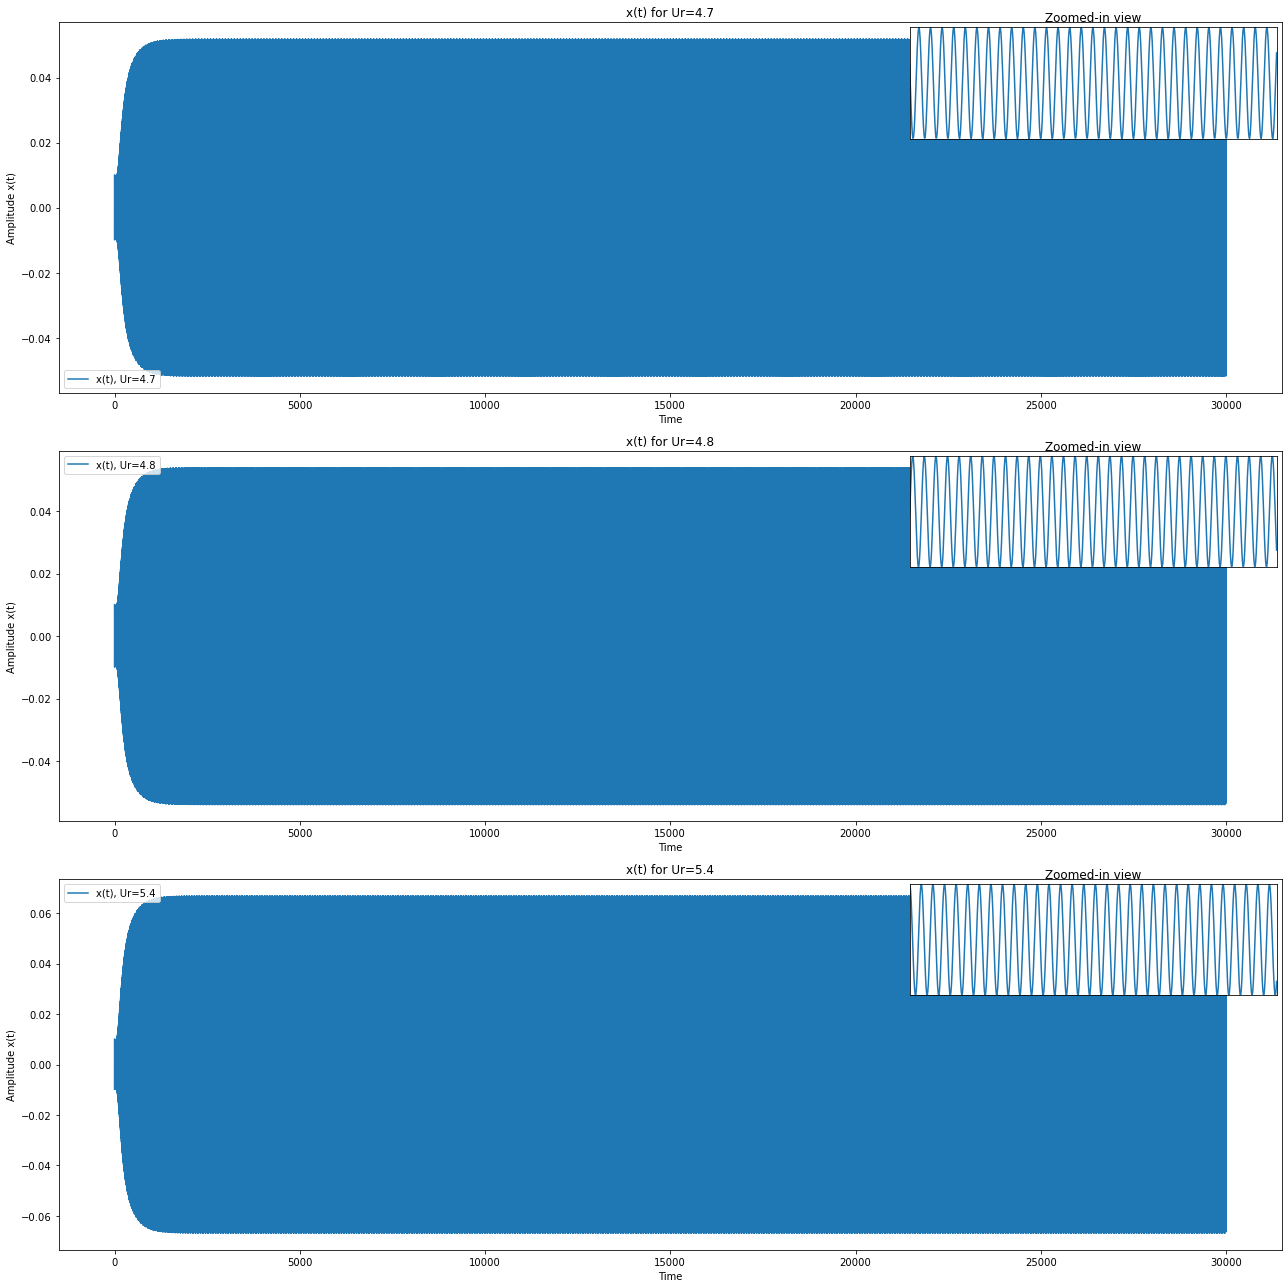

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


a = 0.002
S = 0.2
zeta = 0.0015
b = 0.4
alpha = 0.02


def odes(state, t, a, S, zeta, Ur):
    omega_knot = S * Ur
    x, v, Cl, p = state
    x_dot = v
    v_dot = a * omega_knot**2 * Cl - x - (2 * zeta * v)
    Cl_dot = p
    p_dot = b * v + 0.02 * p - 1 * Cl - 0.66 * (p**3)
    return [x_dot, v_dot, Cl_dot, p_dot]


initial_state = [0.01, 0.0, 0, 0]
t_points = np.linspace(0, 30000, 100000)


Ur_values = [4.7, 4.8, 5.4]


fig, axes = plt.subplots(len(Ur_values), 1, figsize=(18, 6 * len(Ur_values)))

for i, Ur in enumerate(Ur_values):
    solution = odeint(odes, initial_state, t_points, args=(a, S, zeta, Ur))
    x_t = solution[:, 0]


    axes[i].plot(t_points, x_t, label=f'x(t), Ur={Ur}')
    axes[i].set_title(f'x(t) for Ur={Ur}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude x(t)')
    axes[i].legend()


    axins = inset_axes(axes[i], width="30%", height="30%", loc='upper right')
    axins.plot(t_points, x_t, label=f'x(t), Ur={Ur}')
    zoom_start, zoom_end = 29800, 30000  # Adjust the zoom window as needed
    axins.set_xlim(zoom_start, zoom_end)
    axins.set_ylim(min(x_t[zoom_start:zoom_end]), max(x_t[zoom_start:zoom_end]))
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_title('Zoomed-in view')

plt.tight_layout()
plt.show()


fig.savefig('wake-Lift.png', dpi=300)


The above results, clearly shows that, to model a lift-oscillator, VIV System, we need to take control of the omega_knot, which in turn depends on the Ur. The lift oscillator model, unlike the wake oscillator model, is dependent of the velocity of the incoming flow. Without a control variable of omega_knot, it is impossible to get a Sparse Model, which is reasonably accurate enough to give us the representation of the true dynamics of the system.

SINDy with Control variable omega_knot.
1) Need to prepare the data set to include omega_knot as a separate variable.
2) Omega_knot = Strouhal_Number x Ur
3) Considering the 3 velocities only, we will generate a array and stack upon the theta matrix of the lasso.